**Import Library & Preprocessing Data (Augmentasi)**

In [17]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi Path & Parameter
BASE_DIR = 'C:/KULIAH/Semester 7/Machine Learning/Codingan/ujian_akhir_praktikum/data'  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15           

In [18]:
def load_coco_json(dataset_path, subset):
    """
    Membaca file _annotations.coco.json dan mengubahnya menjadi DataFrame.
    """
    json_path = os.path.join(dataset_path, subset, '_annotations.coco.json')
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Mapping ID ke Nama
    categories = {cat['id']: cat['name'] for cat in data['categories']}
    images = {img['id']: img['file_name'] for img in data['images']}
    
    dataset = []
    for ann in data['annotations']:
        img_id = ann['image_id']
        cat_id = ann['category_id']
        file_name = images[img_id]
        class_name = categories[cat_id]
        
        # Validasi keberadaan file
        full_path = os.path.join(dataset_path, subset, file_name)
        if os.path.exists(full_path):
            dataset.append({'filename': file_name, 'class': class_name})
            
    return pd.DataFrame(dataset)

# Load Dataframes
df_train = load_coco_json(BASE_DIR, 'train')
df_valid = load_coco_json(BASE_DIR, 'valid')
df_test = load_coco_json(BASE_DIR, 'test')

# --- FIX UTAMA: Standarisasi Kelas ---
# Mengambil daftar kelas unik dari data training dan mengurutkannya
all_classes = sorted(df_train['class'].unique().tolist())
num_classes = len(all_classes)

print(f"Data Train: {len(df_train)}")
print(f"Data Valid: {len(df_valid)}")
print(f"Data Test : {len(df_test)}")
print(f"Total Kelas: {num_classes}")
print(f"List Kelas : {all_classes}")

Data Train: 16880
Data Valid: 1805
Data Test : 1563
Total Kelas: 17
List Kelas : ['Auricularia auricula', 'Boletus', 'Cantharellus cibarius', 'Clitocybe maxima', 'Collybia albuminosa', 'Coprinus comatus', 'Cordyceps militaris', 'Dictyophora indusiate', 'Flammulina velutiper', 'Hericium erinaceus', 'Hypsizygus marmoreus', 'Lentinus edodes', 'Morchella esculenta', 'Pleurotus citrinopileatus', 'Pleurotus cystidiosus', 'Pleurotus eryngii', 'Pleurotus ostreatus']


In [19]:
# Augmentasi untuk Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale untuk Validasi & Test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Generator Training ---
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=os.path.join(BASE_DIR, 'train'),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes  
)

# --- Generator Validation ---
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=os.path.join(BASE_DIR, 'valid'),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=all_classes  
)

# --- Generator Test ---
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=os.path.join(BASE_DIR, 'test'),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,       
    classes=all_classes  
)

Found 16880 validated image filenames belonging to 17 classes.
Found 843 validated image filenames belonging to 17 classes.
Found 1210 validated image filenames belonging to 17 classes.



=== TRAINING MODEL 1: BASE CNN ===


c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 395s 747ms/step - accuracy: 0.2323 - loss: 2.3821 - val_accuracy: 0.3298 - val_loss: 2.2549
Epoch 2/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 369s 698ms/step - accuracy: 0.3236 - loss: 2.0307 - val_accuracy: 0.4081 - val_loss: 1.8361
Epoch 3/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 368s 697ms/step - accuracy: 0.3905 - loss: 1.8313 - val_accuracy: 0.4353 - val_loss: 1.8734
Epoch 4/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 366s 692ms/step - accuracy: 0.4332 - loss: 1.6992 - val_accuracy: 0.5350 - val_loss: 1.4723
Epoch 5/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 369s 699ms/step - accuracy: 0.4686 - loss: 1.5974 - val_accuracy: 0.5125 - val_loss: 1.5706
Epoch 6/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 374s 708ms/step - accuracy: 0.4956 - loss: 1.5163 - val_accuracy: 0.5635 - val_loss: 1.4040
Epoch 7/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 373s 707ms/step - accuracy: 0.5235 - loss: 1.4345 - val_accuracy: 0.5836 - val_loss: 1.4002
Epoch 8/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 375s 710ms/step - accuracy: 0.5435 -

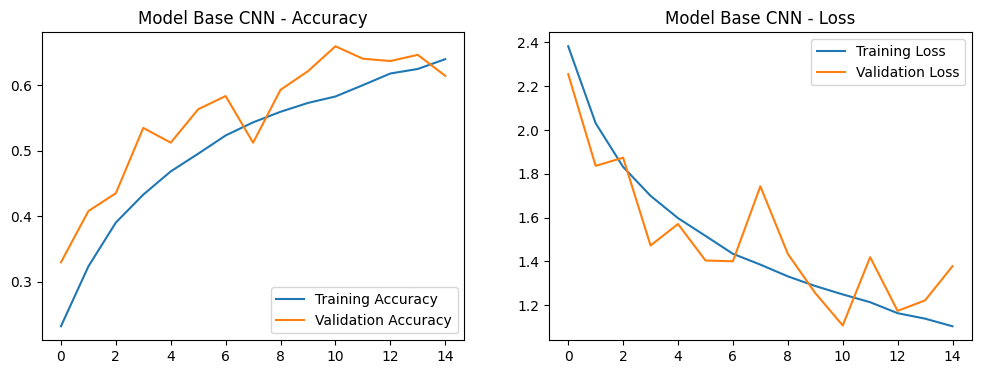

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step

Classification Report:
                           precision    recall  f1-score   support

     Auricularia auricula       0.86      0.16      0.27       315
                  Boletus       0.00      0.00      0.00         0
    Cantharellus cibarius       0.00      0.00      0.00         0
         Clitocybe maxima       0.52      0.30      0.38        47
      Collybia albuminosa       0.00      0.00      0.00         0
         Coprinus comatus       0.00      0.00      0.00         0
      Cordyceps militaris       0.00      0.00      0.00         0
    Dictyophora indusiate       0.00      0.00      0.00         0
     Flammulina velutiper       0.83      0.34      0.48        44
       Hericium erinaceus       0.71      0.80      0.75       144
     Hypsizygus marmoreus       0.65      0.27      0.38        56
          Lentinus edodes       0.91      0.66      0.76       267
      Morchella esculenta       0.35      0.79      0.49      

c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

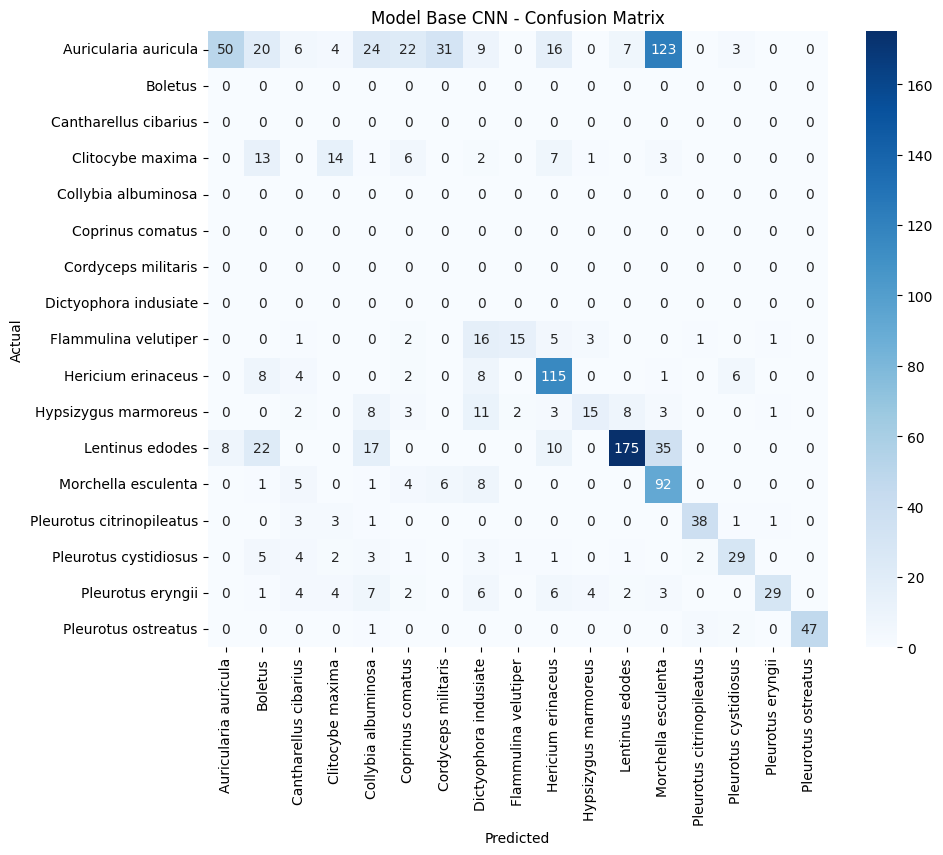

Model berhasil disimpan di: ../models/model_base_cnn.h5



In [22]:
def create_base_cnn(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\n=== TRAINING MODEL 1: BASE CNN ===")
model_base = create_base_cnn(num_classes)
history_base = model_base.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

evaluate_and_save(model_base, history_base, test_generator, "Model Base CNN")


=== TRAINING MODEL 2: MOBILENETV2 ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 286s 537ms/step - accuracy: 0.7363 - loss: 0.8605 - val_accuracy: 0.7877 - val_loss: 0.7257
Epoch 2/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 259s 489ms/step - accuracy: 0.8681 - loss: 0.4136 - val_accuracy: 0.7972 - val_loss: 0.6092
Epoch 3/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 253s 478ms/step - accuracy: 0.9019 - loss: 0.3193 - val_accuracy: 0.7948 - val_loss: 0.5944
Epoch 4/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 255s 482ms/step - accuracy: 0.9140 - loss: 0.2635 - val_accuracy: 0.7972 - val_loss: 0.6344
Epoch 5/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 254s 481ms/step - accuracy: 0.9252 - loss: 0.2298 - val_accuracy: 0.8066 - val_loss: 0.5658
Epoch 6/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 252s 477ms/step - accuracy: 0.9369 - loss: 0.1969 - val_accuracy: 0.8078 - val_loss: 0.7750
Epoch 7/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 240s 454ms/step - accuracy: 0.9428 - loss: 0.1842 - val_accuracy: 0.8221 - val_l

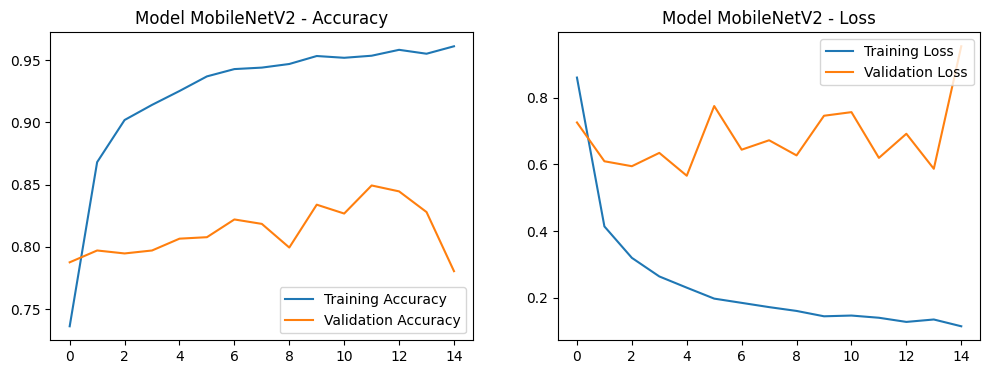

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step

Classification Report:
                           precision    recall  f1-score   support

     Auricularia auricula       0.99      0.49      0.65       315
                  Boletus       0.00      0.00      0.00         0
    Cantharellus cibarius       0.00      0.00      0.00         0
         Clitocybe maxima       0.39      0.66      0.49        47
      Collybia albuminosa       0.00      0.00      0.00         0
         Coprinus comatus       0.00      0.00      0.00         0
      Cordyceps militaris       0.00      0.00      0.00         0
    Dictyophora indusiate       0.00      0.00      0.00         0
     Flammulina velutiper       0.96      0.57      0.71        44
       Hericium erinaceus       0.95      0.86      0.91       144
     Hypsizygus marmoreus       0.80      0.59      0.68        56
          Lentinus edodes       0.95      0.84      0.89       267
      Morchella esculenta       0.97      0.60      0.74      

c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

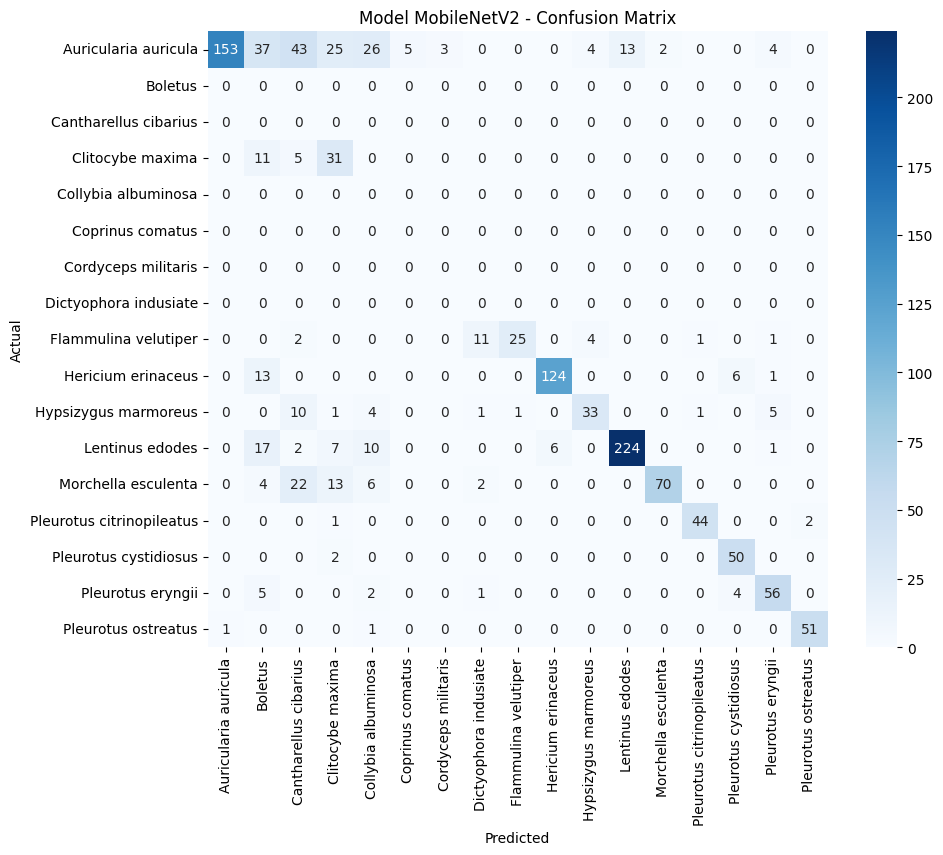

Model berhasil disimpan di: ../models/model_mobilenetv2.h5



In [ ]:
def create_mobilenet(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\n=== TRAINING MODEL 2: MOBILENETV2 ===")
model_mobilenet = create_mobilenet(num_classes)
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

evaluate_and_save(model_mobilenet, history_mobilenet, test_generator, "Model MobileNetV2")


=== TRAINING MODEL 3: RESNET50V2 ===
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 391s 734ms/step - accuracy: 0.7760 - loss: 0.7274 - val_accuracy: 0.8149 - val_loss: 0.6259
Epoch 2/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 394s 746ms/step - accuracy: 0.8930 - loss: 0.3416 - val_accuracy: 0.8695 - val_loss: 0.6554
Epoch 3/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 436s 825ms/step - accuracy: 0.9174 - loss: 0.2587 - val_accuracy: 0.8826 - val_loss: 0.6037
Epoch 4/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 407s 770ms/step - accuracy: 0.9324 - loss: 0.2105 - val_accuracy: 0.8778 - val_loss: 0.8762
Epoch 5/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 394s 747ms/step - accuracy: 0.9382 - loss: 0.1888 - val_accuracy: 0.8719 - val_loss: 0.8362
Epoch 6/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 398s 754ms/step - accuracy: 0.9425 - loss: 0.1758 - val_accuracy: 0.8719 - val_loss: 0.7954
Epoch 7/15
528/528 ━━━━━━━━━━━━━━━━━━━━ 397s 751ms/step - accuracy: 0.9500 - loss: 0.1594 - val_accuracy: 0.8992 - val_

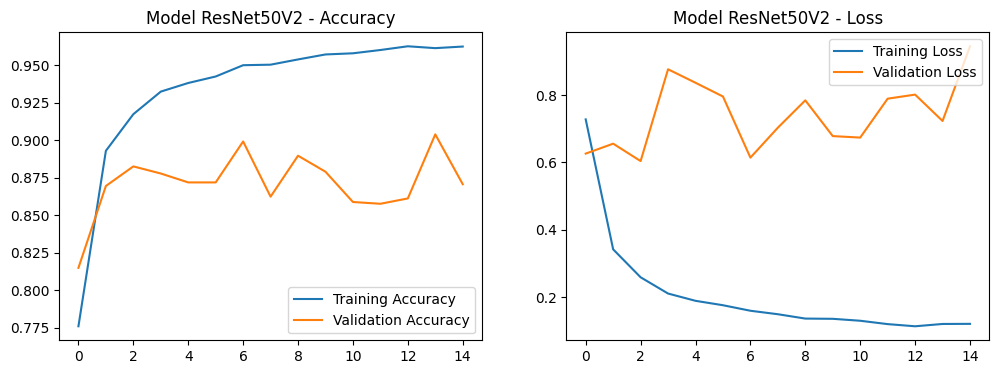

38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 668ms/step

Classification Report:
                           precision    recall  f1-score   support

     Auricularia auricula       1.00      0.49      0.66       315
                  Boletus       0.00      0.00      0.00         0
    Cantharellus cibarius       0.00      0.00      0.00         0
         Clitocybe maxima       0.67      0.66      0.67        47
      Collybia albuminosa       0.00      0.00      0.00         0
         Coprinus comatus       0.00      0.00      0.00         0
      Cordyceps militaris       0.00      0.00      0.00         0
    Dictyophora indusiate       0.00      0.00      0.00         0
     Flammulina velutiper       0.91      0.89      0.90        44
       Hericium erinaceus       0.91      0.92      0.91       144
     Hypsizygus marmoreus       0.82      0.64      0.72        56
          Lentinus edodes       0.86      0.96      0.91       267
      Morchella esculenta       0.85      0.86      0.86      

c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarisRifky\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

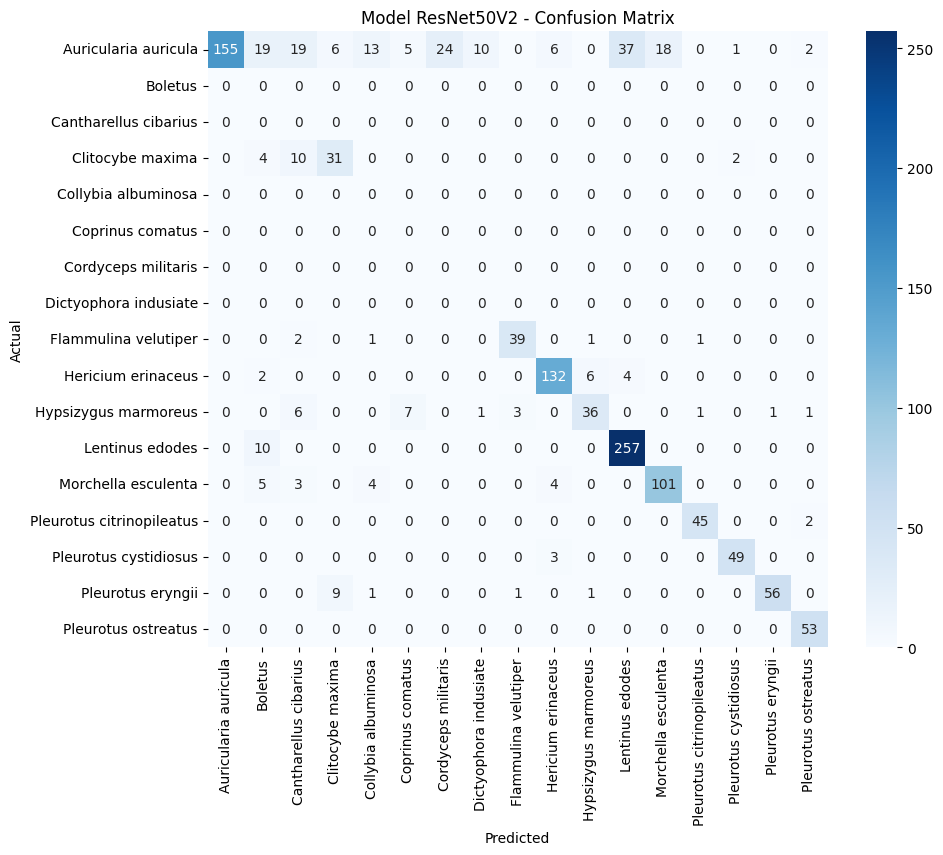

Model berhasil disimpan di: ../models/model_resnet50v2.h5



In [ ]:
def create_resnet(num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\n=== TRAINING MODEL 3: RESNET50V2 ===")
model_resnet = create_resnet(num_classes)
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

evaluate_and_save(model_resnet, history_resnet, test_generator, "Model ResNet50V2")